In [14]:
import keras
keras.__version__

'2.4.3'

# Understanding recurrent neural networks

이 노트북은 [케라스 창시자에게 배우는 딥러닝](https://tensorflow.blog/%EC%BC%80%EB%9D%BC%EC%8A%A4-%EB%94%A5%EB%9F%AC%EB%8B%9D/) 책의 6장 2절의 코드 예제입니다. 책에는 더 많은 내용과 그림이 있습니다. 이 노트북에는 소스 코드에 관련된 설명만 포함합니다.

---

[...]

## 케라스의 순환 층


넘파이로 간단하게 구현한 과정이 실제 케라스의 `SimpleRNN` 층에 해당합니다:

In [15]:
from keras.layers import SimpleRNN

`SimpleRNN`이 한 가지 다른 점은 넘파이 예제처럼 하나의 시퀀스가 아니라 다른 케라스 층과 마찬가지로 시퀀스 배치를 처리한다는 것입니다. 즉, `(timesteps, input_features)` 크기가 아니라 `(batch_size, timesteps, input_features)` 크기의 입력을 받습니다.

케라스에 있는 모든 순환 층과 동일하게 `SimpleRNN`은 두 가지 모드로 실행할 수 있습니다. 각 타임스텝의 출력을 모은 전체 시퀀스를 반환하거나(크기가 `(batch_size, timesteps, output_features)`인 3D 텐서), 입력 시퀀스에 대한 마지막 출력만 반환할 수 있습니다(크기가 `(batch_size, output_features)`인 2D 텐서). 이 모드는 객체를 생성할 때 `return_sequences` 매개변수로 선택할 수 있습니다. 예제를 살펴보죠:

In [16]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_14 (SimpleRNN)    (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [17]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_15 (SimpleRNN)    (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


네트워크의 표현력을 증가시키기 위해 여러 개의 순환 층을 차례대로 쌓는 것이 유용할 때가 있습니다. 이런 설정에서는 중간 층들이 전체 출력 시퀀스를 반환하도록 설정해야 합니다:

In [18]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # 맨 위 층만 마지막 출력을 반환합니다.
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_16 (SimpleRNN)    (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_17 (SimpleRNN)    (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_18 (SimpleRNN)    (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_19 (SimpleRNN)    (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


이제 IMDB 영화 리뷰 분류 문제에 적용해 보죠. 먼저 데이터를 전처리합니다:

In [19]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # 특성으로 사용할 단어의 수
maxlen = 500  # 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용합니다)
batch_size = 32

print('데이터 로딩...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), '훈련 시퀀스')
print(len(input_test), '테스트 시퀀스')

print('시퀀스 패딩 (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train 크기:', input_train.shape)
print('input_test 크기:', input_test.shape)

데이터 로딩...
25000 훈련 시퀀스
25000 테스트 시퀀스
시퀀스 패딩 (samples x time)
input_train 크기: (25000, 500)
input_test 크기: (25000, 500)


`Embedding` 층과 `SimpleRNN` 층을 사용해 간단한 순환 네트워크를 훈련시켜 보겠습니다:

In [20]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 14s 90ms/step - loss: 0.6248 - acc: 0.6323 - val_loss: 0.6593 - val_acc: 0.6502
Epoch 2/10
157/157 [==============================] - 14s 88ms/step - loss: 0.4037 - acc: 0.8267 - val_loss: 0.4487 - val_acc: 0.7894
Epoch 3/10
157/157 [==============================] - 16s 101ms/step - loss: 0.2896 - acc: 0.8862 - val_loss: 0.5197 - val_acc: 0.8002
Epoch 4/10
157/157 [==============================] - 18s 116ms/step - loss: 0.2168 - acc: 0.9178 - val_loss: 0.4099 - val_acc: 0.8568
Epoch 5/10
157/157 [==============================] - 16s 102ms/step - loss: 0.1704 - acc: 0.9376 - val_loss: 0.3906 - val_acc: 0.8486
Epoch 6/10
157/157 [==============================] - 16s 99ms/step - loss: 0.1172 - acc: 0.9592 - val_loss: 0.4507 - val_acc: 0.8058
Epoch 7/10
157/157 [==============================] - 17s 105ms/step - loss: 0.0807 - acc: 0.9723 - val_loss: 0.4355 - val_acc: 0.8438
Epoch 8/10
157/157 [==============================] - 15s 

이제 훈련과 검증의 손실과 정확도를 그래프로 그립니다:

In [21]:
import matplotlib.pyplot as plt

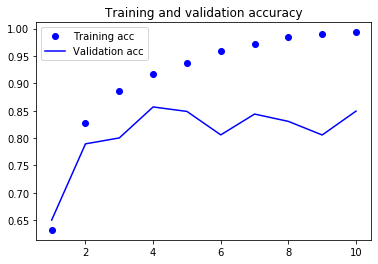

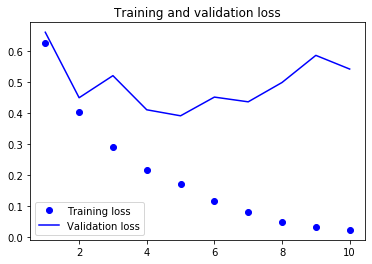

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [23]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # 맨 위 층만 마지막 출력을 반환합니다.


model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history1 = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)


Epoch 1/10
157/157 [==============================] - 27s 171ms/step - loss: 3.8036 - acc: 0.0018 - val_loss: 3.2051 - val_acc: 0.0000e+00
Epoch 2/10
157/157 [==============================] - 29s 184ms/step - loss: 2.9252 - acc: 4.5000e-04 - val_loss: 1.9198 - val_acc: 0.0000e+00
Epoch 3/10
157/157 [==============================] - 29s 183ms/step - loss: 1.6127 - acc: 6.0000e-04 - val_loss: 1.1543 - val_acc: 4.0000e-04
Epoch 4/10
157/157 [==============================] - 29s 184ms/step - loss: 1.0932 - acc: 0.0196 - val_loss: 1.0459 - val_acc: 0.0084
Epoch 5/10
157/157 [==============================] - 30s 193ms/step - loss: 0.9557 - acc: 0.0149 - val_loss: 0.8070 - val_acc: 8.0000e-04
Epoch 6/10
157/157 [==============================] - 28s 177ms/step - loss: 0.6877 - acc: 0.0088 - val_loss: 0.7695 - val_acc: 0.0196
Epoch 7/10
157/157 [==============================] - 32s 201ms/step - loss: 0.5041 - acc: 0.0554 - val_loss: 0.6308 - val_acc: 0.0046
Epoch 8/10
157/157 [===========

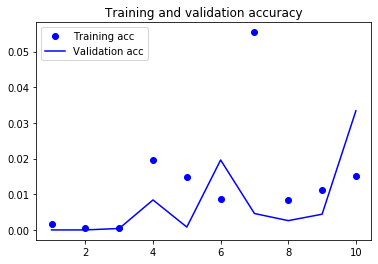

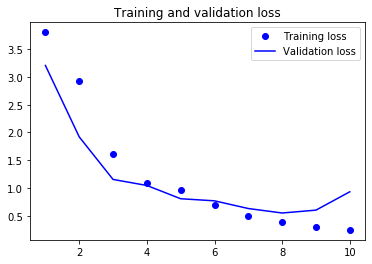

In [24]:
acc = history1.history['acc']
val_acc = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [25]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # 맨 위 층만 마지막 출력을 반환합니다.


model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)


Epoch 1/10
157/157 [==============================] - 70s 443ms/step - loss: 2.7740 - acc: 0.0110 - val_loss: 2.6487 - val_acc: 0.0000e+00
Epoch 2/10
157/157 [==============================] - 69s 438ms/step - loss: 2.6545 - acc: 0.0593 - val_loss: 2.6742 - val_acc: 0.0016
Epoch 3/10
157/157 [==============================] - 71s 451ms/step - loss: 2.2438 - acc: 0.0545 - val_loss: 2.3829 - val_acc: 0.0000e+00
Epoch 4/10
157/157 [==============================] - 74s 471ms/step - loss: 1.9730 - acc: 0.0137 - val_loss: 2.9638 - val_acc: 0.0000e+00
Epoch 5/10
157/157 [==============================] - 72s 461ms/step - loss: 1.8554 - acc: 0.0049 - val_loss: 4.0395 - val_acc: 0.0424
Epoch 6/10
157/157 [==============================] - 73s 462ms/step - loss: 1.7885 - acc: 0.0176 - val_loss: 3.7948 - val_acc: 0.0166
Epoch 7/10
157/157 [==============================] - 72s 461ms/step - loss: 1.7398 - acc: 0.0019 - val_loss: 4.6737 - val_acc: 0.0120
Epoch 8/10
157/157 [=======================

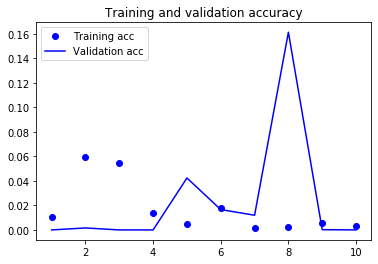

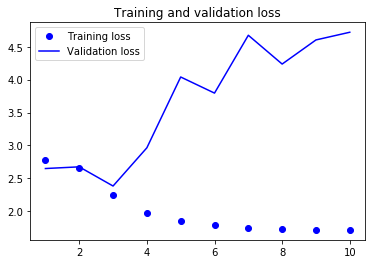

In [26]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [29]:
input_train.shape

(25000, 500)